# Initialising

In [ ]:
# setting up AIcrowd CLI
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/b0T6zkXCVhc7cc1wwrAQqmRJvFVdz5mrj-7LhY29Hqo
API Key valid
Saved API Key successfully!


In [ ]:
# Downloading the Dataset
!rm -rf data
!mkdir data
%aicrowd ds dl -c foodch -o data

train_images.zip:   0%|          | 0.00/754M [00:00<?, ?B/s]

test_images.zip:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/253k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

In [ ]:
!unzip data/train_images -d data/train_images > /dev/null
!unzip data/test_images -d data/test_images > /dev/null

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Loading the data

In [ ]:
train_image_dir = Path('data/train_images/train_images')

In [ ]:
# creating file dataframe
filepaths = list(train_image_dir.glob(r'**/*.jpg'))

In [ ]:
str(filepaths[0])

'data/train_images/train_images/b7fa20f4f5.jpg'

In [ ]:
os.path.split(filepaths[0])[1]

'b7fa20f4f5.jpg'

In [ ]:
path_ex = 'data/train_images/train_images/' + 'b7fa20f4f5.jpg'
path_ex

'data/train_images/train_images/b7fa20f4f5.jpg'

In [ ]:
full_df = pd.read_csv('data/train.csv')

In [ ]:
full_df

,ImageId,ClassName
0,f27632d7e5.jpg,water
1,efa87919ed.jpg,pizza-margherita-baked
2,4f169e8c8d.jpg,broccoli
3,a6956654bf.jpg,salad-leaf-salad-green
4,d99ce8c3bf.jpg,egg
...,...,...
9318,ba8233c7d2.jpg,bread-french-white-flour
9319,2090043907.jpg,wine-red
9320,8762d1cefd.jpg,carrot
9321,28e7439245.jpg,broccoli


In [ ]:
full_df.isnull().sum()

ImageId      0
ClassName    0
dtype: int64

In [ ]:
full_df["filepath"] = 'data/train_images/train_images/' + full_df["ImageId"]
full_df

,ImageId,ClassName,filepath
0,f27632d7e5.jpg,water,data/train_images/train_images/f27632d7e5.jpg
1,efa87919ed.jpg,pizza-margherita-baked,data/train_images/train_images/efa87919ed.jpg
2,4f169e8c8d.jpg,broccoli,data/train_images/train_images/4f169e8c8d.jpg
3,a6956654bf.jpg,salad-leaf-salad-green,data/train_images/train_images/a6956654bf.jpg
4,d99ce8c3bf.jpg,egg,data/train_images/train_images/d99ce8c3bf.jpg
...,...,...,...
9318,ba8233c7d2.jpg,bread-french-white-flour,data/train_images/train_images/ba8233c7d2.jpg
9319,2090043907.jpg,wine-red,data/train_images/train_images/2090043907.jpg
9320,8762d1cefd.jpg,carrot,data/train_images/train_images/8762d1cefd.jpg
9321,28e7439245.jpg,broccoli,data/train_images/train_images/28e7439245.jpg


In [ ]:
full_df["ClassName"].value_counts()

water                     863
bread-white               595
salad-leaf-salad-green    535
bread-wholemeal           398
coffee-with-caffeine      377
                         ... 
soft-cheese                48
mayonnaise                 43
onion                      41
corn                       37
pickle                     28
Name: ClassName, Length: 61, dtype: int64

# Train Test Split

In [ ]:
# train test split
train_df, test_df = train_test_split(full_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
# creating generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Generators to load Images

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='ClassName',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='ClassName',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='ClassName',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5221 validated image filenames belonging to 61 classes.
Found 1305 validated image filenames belonging to 61 classes.
Found 2797 validated image filenames belonging to 61 classes.


# Modeling

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(61, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
164/164 [==============================] - 66s 332ms/step - loss: 2.5144 - accuracy: 0.3700 - val_loss: 2.0465 - val_accuracy: 0.4575
Epoch 2/100
164/164 [==============================] - 52s 313ms/step - loss: 1.6255 - accuracy: 0.5420 - val_loss: 1.8395 - val_accuracy: 0.4912
Epoch 3/100
164/164 [==============================] - 54s 327ms/step - loss: 1.2938 - accuracy: 0.6167 - val_loss: 1.8771 - val_accuracy: 0.5019
Epoch 4/100
164/164 [==============================] - 53s 325ms/step - loss: 1.0556 - accuracy: 0.6824 - val_loss: 1.8298 - val_accuracy: 0.4966
Epoch 5/100
164/164 [==============================] - 53s 325ms/step - loss: 0.8608 - accuracy: 0.7345 - val_loss: 1.9810 - val_accuracy: 0.4874
Epoch 6/100
164/164 [==============================] - 53s 326ms/step - loss: 0.6705 - accuracy: 0.7979 - val_loss: 2.0190 - val_accuracy: 0.4782
Epoch 7/100
164/164 [==============================] - 54s 326ms/step - loss: 0.5233 - accuracy: 0.8412 - val_loss: 2.1745 -

# Results

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 52.02%


In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

In [ ]:
predictions

array([49, 55, 53, ..., 18,  9, 25])

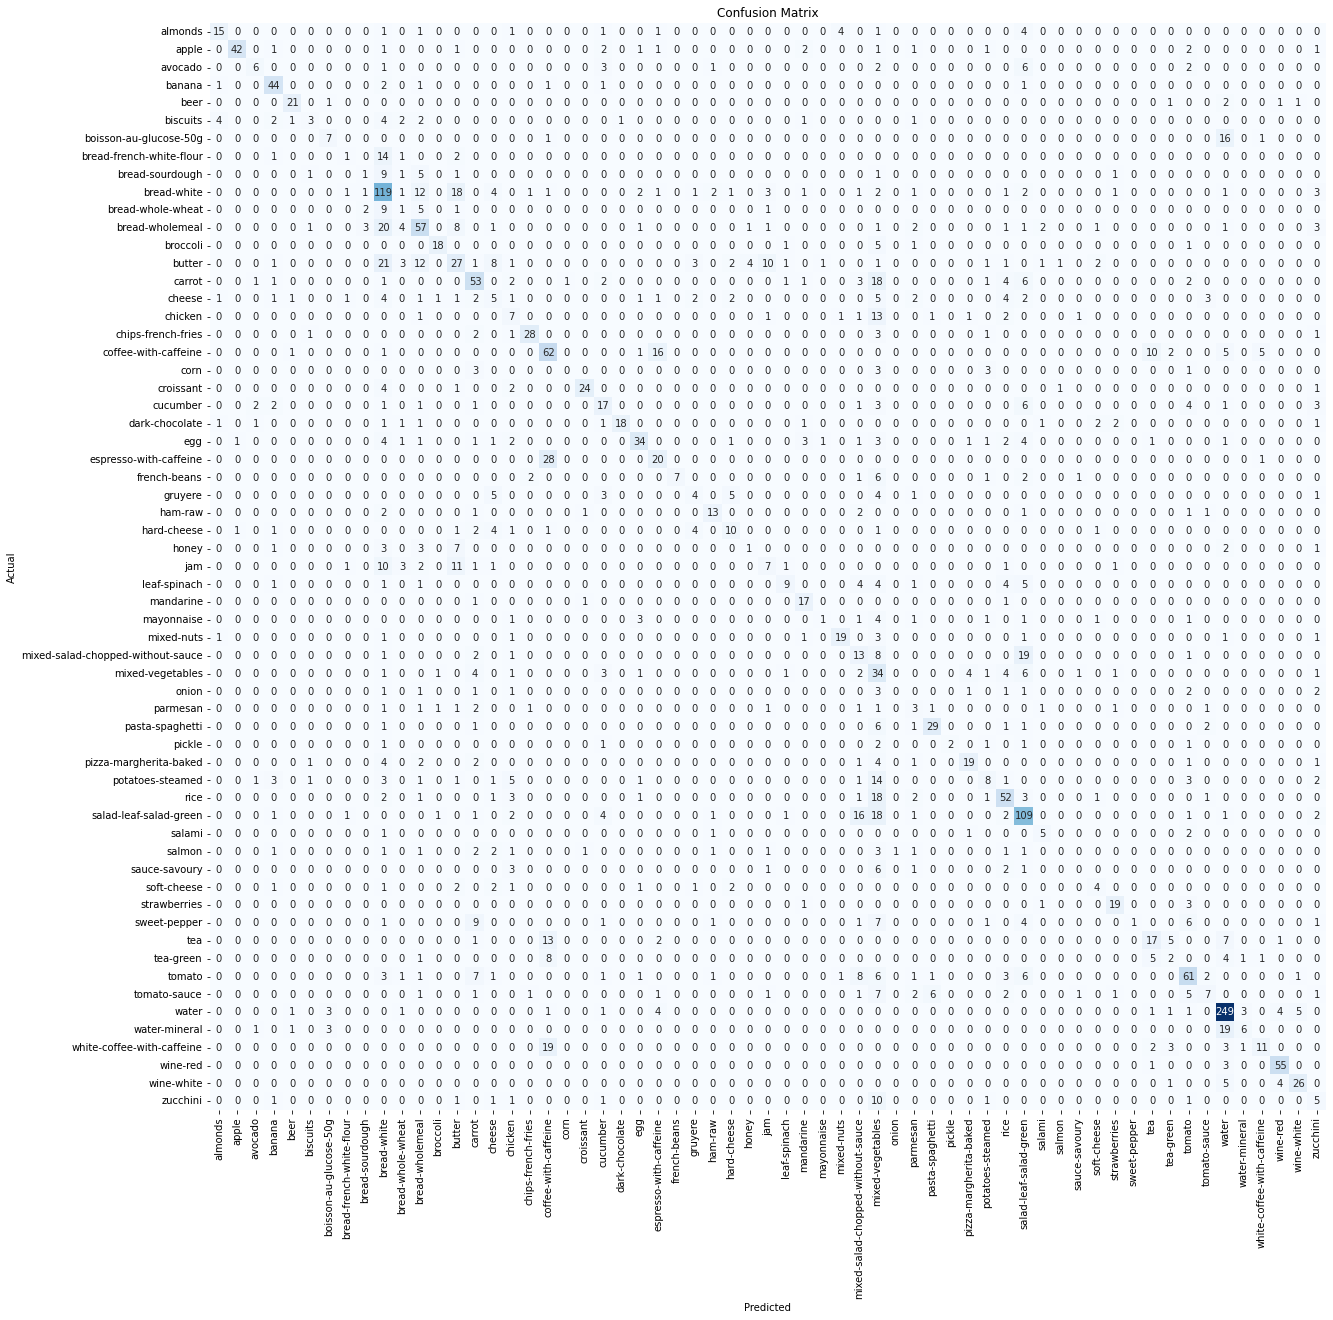

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(61) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(61) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(clr)

                                   precision    recall  f1-score   support

                          almonds       0.65      0.52      0.58        29
                            apple       0.95      0.74      0.83        57
                          avocado       0.50      0.29      0.36        21
                           banana       0.70      0.86      0.77        51
                             beer       0.81      0.78      0.79        27
                         biscuits       0.38      0.14      0.21        21
           boisson-au-glucose-50g       0.50      0.28      0.36        25
         bread-french-white-flour       0.20      0.05      0.08        19
                  bread-sourdough       0.14      0.05      0.07        20
                      bread-white       0.46      0.66      0.54       181
                bread-whole-wheat       0.05      0.05      0.05        19
                  bread-wholemeal       0.49      0.52      0.51       109
                        

# Preparing for Submission

In [ ]:
test_sub = pd.read_csv('data/test.csv')

In [ ]:
test_sub

,ImageId
0,90e63a2fde.jpg
1,a554d1ca8d.jpg
2,48317e8ee8.jpg
3,79528df667.jpg
4,6d2f2f63f5.jpg
...,...
479,843b8695df.jpg
480,584490f483.jpg
481,d5df1ab5ec.jpg
482,79e3e01b88.jpg


In [ ]:
test_sub["filepath"] = 'data/test_images/test_images/' + test_sub["ImageId"]
test_sub

,ImageId,filepath
0,90e63a2fde.jpg,data/test_images/test_images/90e63a2fde.jpg
1,a554d1ca8d.jpg,data/test_images/test_images/a554d1ca8d.jpg
2,48317e8ee8.jpg,data/test_images/test_images/48317e8ee8.jpg
3,79528df667.jpg,data/test_images/test_images/79528df667.jpg
4,6d2f2f63f5.jpg,data/test_images/test_images/6d2f2f63f5.jpg
...,...,...
479,843b8695df.jpg,data/test_images/test_images/843b8695df.jpg
480,584490f483.jpg,data/test_images/test_images/584490f483.jpg
481,d5df1ab5ec.jpg,data/test_images/test_images/d5df1ab5ec.jpg
482,79e3e01b88.jpg,data/test_images/test_images/79e3e01b88.jpg


In [ ]:
testsub_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
testsub_images = testsub_generator.flow_from_directory('data/test_images',
                              classes=['test_images'],
                              class_mode=None,
                              shuffle=False,
                              target_size=(224, 224))
predictions = np.argmax(model.predict(testsub_images), axis=1)

Found 484 images belonging to 1 classes.


In [ ]:
predictions

array([26, 36,  1, 13, 55, 23, 23, 58, 39, 49, 39, 14, 38,  9, 25, 14,  3,
       25, 11, 44,  2, 55,  9, 11, 16,  2, 55,  9, 44, 45, 32, 17, 16,  1,
       14, 36, 59, 18,  9, 36, 35, 51, 36, 58, 53, 14, 18, 26, 23, 44, 26,
       11,  9, 21, 18, 39,  3,  3, 22, 14, 55, 24,  1, 44, 57, 22, 18, 18,
       55, 35, 44, 44,  9, 35, 15, 18, 55, 55, 17, 55,  9, 42, 28, 13, 53,
       15, 27, 36, 14, 11,  9, 17, 16, 55, 58, 59, 11, 36,  2, 12, 39, 39,
       36,  9, 35, 13, 33, 55, 30, 55, 44, 43, 35, 55, 55, 58, 43, 13, 55,
       24, 55,  3, 60, 24, 12, 60, 43,  8, 14, 11, 41, 42, 36, 41, 36, 44,
       46, 24, 36, 12, 14, 58, 53, 17, 18, 53, 11, 55, 39, 11, 36, 23,  9,
       43, 43, 57, 36, 55, 18,  9,  9, 18, 44,  9, 44, 36, 11, 44,  0, 36,
       43, 43,  9,  9, 36,  3,  9,  9, 58, 25, 43, 18, 51, 14, 44, 12, 41,
       21,  9, 53, 13, 54,  9, 43, 36,  0, 18, 14, 18, 54, 36, 44, 13, 53,
       55, 17, 35, 23,  1, 31,  9, 11, 42, 55,  3,  8, 13,  9, 11,  9, 55,
       44, 15, 10, 17, 36

In [ ]:
# mapping class indices to labels
idx_to_cls = {v: k for k, v in test_images.class_indices.items()}
preds_cls = np.vectorize(idx_to_cls.get)(predictions)
filenames_to_cls = list(zip(testsub_images.filenames, preds_cls))

In [ ]:
len(preds_cls)

484

In [ ]:
filenames_to_cls

[('test_images/00befedd19.jpg', 'gruyere'),
 ('test_images/0206101929.jpg', 'mixed-vegetables'),
 ('test_images/022a8608b9.jpg', 'apple'),
 ('test_images/034292a8ff.jpg', 'butter'),
 ('test_images/0428e62301.jpg', 'water'),
 ('test_images/043d33679c.jpg', 'egg'),
 ('test_images/0465f6d586.jpg', 'egg'),
 ('test_images/04cddbbf04.jpg', 'wine-red'),
 ('test_images/05f5a5379d.jpg', 'pasta-spaghetti'),
 ('test_images/06173b9a49.jpg', 'strawberries'),
 ('test_images/06892a0b2c.jpg', 'pasta-spaghetti'),
 ('test_images/073bb56ea3.jpg', 'carrot'),
 ('test_images/07f797c8f9.jpg', 'parmesan'),
 ('test_images/08510c1eeb.jpg', 'bread-white'),
 ('test_images/08dabf6d3d.jpg', 'french-beans'),
 ('test_images/0907979c42.jpg', 'carrot'),
 ('test_images/0920aa3bf3.jpg', 'banana'),
 ('test_images/0923a486ff.jpg', 'french-beans'),
 ('test_images/097c66c0b2.jpg', 'bread-wholemeal'),
 ('test_images/0a19f83a26.jpg', 'salad-leaf-salad-green'),
 ('test_images/0a3c32bc94.jpg', 'avocado'),
 ('test_images/0a8b8ad7

In [ ]:
test_images.class_indices

{'almonds': 0,
 'apple': 1,
 'avocado': 2,
 'banana': 3,
 'beer': 4,
 'biscuits': 5,
 'boisson-au-glucose-50g': 6,
 'bread-french-white-flour': 7,
 'bread-sourdough': 8,
 'bread-white': 9,
 'bread-whole-wheat': 10,
 'bread-wholemeal': 11,
 'broccoli': 12,
 'butter': 13,
 'carrot': 14,
 'cheese': 15,
 'chicken': 16,
 'chips-french-fries': 17,
 'coffee-with-caffeine': 18,
 'corn': 19,
 'croissant': 20,
 'cucumber': 21,
 'dark-chocolate': 22,
 'egg': 23,
 'espresso-with-caffeine': 24,
 'french-beans': 25,
 'gruyere': 26,
 'ham-raw': 27,
 'hard-cheese': 28,
 'honey': 29,
 'jam': 30,
 'leaf-spinach': 31,
 'mandarine': 32,
 'mayonnaise': 33,
 'mixed-nuts': 34,
 'mixed-salad-chopped-without-sauce': 35,
 'mixed-vegetables': 36,
 'onion': 37,
 'parmesan': 38,
 'pasta-spaghetti': 39,
 'pickle': 40,
 'pizza-margherita-baked': 41,
 'potatoes-steamed': 42,
 'rice': 43,
 'salad-leaf-salad-green': 44,
 'salami': 45,
 'salmon': 46,
 'sauce-savoury': 47,
 'soft-cheese': 48,
 'strawberries': 49,
 'sweet

In [ ]:
finaldf = pd.DataFrame({'Filename': testsub_images.filenames,'Prediction': preds_cls})
finaldf

,Filename,Prediction
0,test_images/00befedd19.jpg,gruyere
1,test_images/0206101929.jpg,mixed-vegetables
2,test_images/022a8608b9.jpg,apple
3,test_images/034292a8ff.jpg,butter
4,test_images/0428e62301.jpg,water
...,...,...
479,test_images/fea1eae00b.jpg,bread-white
480,test_images/ff5a63f32a.jpg,mixed-vegetables
481,test_images/ff7ce27028.jpg,mixed-nuts
482,test_images/ff8c0a5300.jpg,bread-white


In [ ]:
finaldf["Filename"] = 'data/test_images/' + finaldf["Filename"]

In [ ]:
finaldf

,Filename,Prediction
0,data/test_images/test_images/00befedd19.jpg,gruyere
1,data/test_images/test_images/0206101929.jpg,mixed-vegetables
2,data/test_images/test_images/022a8608b9.jpg,apple
3,data/test_images/test_images/034292a8ff.jpg,butter
4,data/test_images/test_images/0428e62301.jpg,water
...,...,...
479,data/test_images/test_images/fea1eae00b.jpg,bread-white
480,data/test_images/test_images/ff5a63f32a.jpg,mixed-vegetables
481,data/test_images/test_images/ff7ce27028.jpg,mixed-nuts
482,data/test_images/test_images/ff8c0a5300.jpg,bread-white


In [ ]:
test_sub

,ImageId,filepath
0,90e63a2fde.jpg,data/test_images/test_images/90e63a2fde.jpg
1,a554d1ca8d.jpg,data/test_images/test_images/a554d1ca8d.jpg
2,48317e8ee8.jpg,data/test_images/test_images/48317e8ee8.jpg
3,79528df667.jpg,data/test_images/test_images/79528df667.jpg
4,6d2f2f63f5.jpg,data/test_images/test_images/6d2f2f63f5.jpg
...,...,...
479,843b8695df.jpg,data/test_images/test_images/843b8695df.jpg
480,584490f483.jpg,data/test_images/test_images/584490f483.jpg
481,d5df1ab5ec.jpg,data/test_images/test_images/d5df1ab5ec.jpg
482,79e3e01b88.jpg,data/test_images/test_images/79e3e01b88.jpg


In [ ]:
testingsub = test_sub
testingsub

,ImageId,filepath
0,90e63a2fde.jpg,data/test_images/test_images/90e63a2fde.jpg
1,a554d1ca8d.jpg,data/test_images/test_images/a554d1ca8d.jpg
2,48317e8ee8.jpg,data/test_images/test_images/48317e8ee8.jpg
3,79528df667.jpg,data/test_images/test_images/79528df667.jpg
4,6d2f2f63f5.jpg,data/test_images/test_images/6d2f2f63f5.jpg
...,...,...
479,843b8695df.jpg,data/test_images/test_images/843b8695df.jpg
480,584490f483.jpg,data/test_images/test_images/584490f483.jpg
481,d5df1ab5ec.jpg,data/test_images/test_images/d5df1ab5ec.jpg
482,79e3e01b88.jpg,data/test_images/test_images/79e3e01b88.jpg


In [ ]:
# merging 2 Dataframes on a common column with MAP
testingsub['ClassName'] = testingsub.filepath.map(finaldf.set_index('Filename')['Prediction'])
testingsub

,ImageId,filepath,ClassName
0,90e63a2fde.jpg,data/test_images/test_images/90e63a2fde.jpg,water
1,a554d1ca8d.jpg,data/test_images/test_images/a554d1ca8d.jpg,water
2,48317e8ee8.jpg,data/test_images/test_images/48317e8ee8.jpg,water
3,79528df667.jpg,data/test_images/test_images/79528df667.jpg,cheese
4,6d2f2f63f5.jpg,data/test_images/test_images/6d2f2f63f5.jpg,bread-white
...,...,...,...
479,843b8695df.jpg,data/test_images/test_images/843b8695df.jpg,broccoli
480,584490f483.jpg,data/test_images/test_images/584490f483.jpg,pasta-spaghetti
481,d5df1ab5ec.jpg,data/test_images/test_images/d5df1ab5ec.jpg,water
482,79e3e01b88.jpg,data/test_images/test_images/79e3e01b88.jpg,bread-whole-wheat


In [ ]:
pred_df = pd.DataFrame()
pred_df["ClassName"] = testingsub["ClassName"]
pred_df

,ClassName
0,water
1,water
2,water
3,cheese
4,bread-white
...,...
479,broccoli
480,pasta-spaghetti
481,water
482,bread-whole-wheat


In [ ]:
# Saving the dataframe to csv
pred_df.to_csv("submission.csv", index=False)

In [ ]:
# Submitting the Predictions

!aicrowd submission create -c foodch -f submission.csv

submission.csv ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0% • 7.8/6.2 KB • ? • 0:00:00
                                                ╭─────────────────────────╮                                                 
                                                │ Successfully submitted! │                                                 
                                                ╰─────────────────────────╯                                                 
                                                      Important links                                                       
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/kiit-ai-mini-blitz/problems/foodch/submissions/166311              │
│                  │                                                                                                       │
│  All submissions │ https://www.aicrowd.com

## This achieved a F1 Score of **0.529** which is in the lead as of now.